#  Proyecto de Clasificación de Ritmos Cardíacos con ECG (PhysioNet 2017)

Este proyecto se basa en el procesamiento y análisis de señales electrocardiográficas (ECG) del **PhysioNet Challenge 2017**. Utilizamos los archivos `.mat` y `.hea` proporcionados para extraer características de los intervalos RR, y clasificamos los registros como **Normal (N)** o **Fibrilación Auricular (AFib, A)**.

## Objetivo
Explorar, visualizar y clasificar ritmos cardíacos usando ingeniería de características sobre intervalos RR.

## Referencias

- PhysioNet/CinC Challenge 2017: https://physionet.org/content/challenge-2017/1.0.0/
- Goldberger AL, et al. "PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals." *Circulation* 101(23):e215-e220, 2000.
- [Biosppy toolbox - Biosignal Processing](https://github.com/PIA-Group/BioSPPy)
- WFDB Python Toolkit: https://github.com/MIT-LCP/wfdb-python

##  Librerías utilizadas

- `wfdb`: Para leer señales fisiológicas desde archivos `.mat` y `.hea`.
- `biosppy`: Para detectar picos R de forma robusta.
- `scipy`, `numpy`, `pandas`: Para análisis estadístico y manejo de datos.
- `matplotlib`, `seaborn`: Para visualización.

---


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from biosppy.signals import ecg
import wfdb


DATASET_DIR = 'training2017'
REFERENCE_PATH = os.path.join(DATASET_DIR, 'REFERENCE.csv')

# Cargar labels desde el archivo REFERENCE.csv
reference = pd.read_csv(REFERENCE_PATH, header=None, names=["record", "label"])

# Lista de IDs de los ECGs
ecg_ids = reference["record"].tolist()

# Crear lista para guardar resultados
features = []

# Iterar sobre todos los archivos
for ecg_id in ecg_ids:
    try:
        record_path = os.path.join(DATASET_DIR, ecg_id)
        record = wfdb.rdrecord(record_path)

        # Extraer señal y frecuencia de muestreo
        signal = record.p_signal[:, 0]  # canal 0
        fs = record.fs

        # Usar biosppy para procesar ECG y detectar R-peaks
        out = ecg.ecg(signal=signal, sampling_rate=fs, show=False)
        r_peaks = out['rpeaks']

        # Calcular intervalos RR (en milisegundos)
        rr = np.diff(r_peaks) / fs * 1000

        if len(rr) > 1:
            mean_rr = np.mean(rr)
            std_rr = np.std(rr)
            skew_rr = skew(rr)
            kurt_rr_val = kurtosis(rr)
        else:
            mean_rr = std_rr = skew_rr = kurt_rr_val = np.nan

        label = reference.loc[reference["record"] == ecg_id, "label"].values[0]

        features.append({
            "id": ecg_id,
            "mean_rr": mean_rr,
            "std_rr": std_rr,
            "skew_rr": skew_rr,
            "kurt_rr": kurt_rr_val,
            "label": label
        })

    except Exception as e:
        print(f"Error con {ecg_id}: {e}")
        continue

# Crear DataFrame y guardar CSV
df = pd.DataFrame(features)
output_path = os.path.join( "ecg_rr_features_curado.csv")
df.to_csv(output_path, index=False)

print("CSV generado exitosamente:", output_path)


✅ CSV generado exitosamente: training2017\ecg_rr_features_curado.csv


In [ ]:
import pandas as pd

# Ruta del CSV original generado anteriormente
csv_path = 'ecg_rr_features_curado.csv' 

# Cargar dataset
df = pd.read_csv(csv_path)

# Verificar etiquetas disponibles
print("Distribución original:\n", df['label'].value_counts())

# Seleccionar 15 muestras de cada clase (N y A)
df_N = df[df['label'] == 'N'].sample(n=15, random_state=42)
df_A = df[df['label'] == 'A'].sample(n=15, random_state=42)

# Combinar y mezclar las muestras
df_balanceado = pd.concat([df_N, df_A]).sample(frac=1, random_state=42).reset_index(drop=True)

# Guardar nuevo CSV
output_path = 'ecg_rr_features_30_balanceado.csv'
df_balanceado.to_csv(output_path, index=False)

print(f"Nuevo CSV guardado como: {output_path}")


Distribución original:
 label
N    5050
O    2456
A     738
~     284
Name: count, dtype: int64
Nuevo CSV guardado como: ecg_rr_features_30_balanceado.csv


In [ ]:
import pandas as pd

# Cargar el CSV de 30 casos balanceados
df = pd.read_csv("ecg_rr_features_30_balanceado.csv")

# Inspección básica
print(" Primeras filas:")
display(df.head())

print("\n Descripción estadística:")
display(df.describe())

print("\n Tipos de datos:")
display(df.dtypes)


📌 Primeras filas:


,id,mean_rr,std_rr,skew_rr,kurt_rr,label
0,A06397,613.546099,199.898797,1.168773,1.350203,A
1,A02900,383.244444,127.736967,1.619724,3.183308,A
2,A05366,531.851852,75.598209,0.668771,0.890665,A
3,A02375,577.687075,145.318797,1.677749,3.186396,A
4,A04689,999.642857,62.781678,1.335801,0.459524,N



📊 Descripción estadística:


,mean_rr,std_rr,skew_rr,kurt_rr
count,30.000000,30.000000,30.000000,30.000000
mean,802.005397,97.708348,0.106184,1.674042
std,245.209851,67.097005,1.341723,4.743288
min,383.244444,13.656897,-3.718210,-1.088567
25%,589.324904,39.889314,-0.482938,-0.743942
50%,796.694678,84.084199,-0.005178,0.406078
75%,1009.196429,141.262828,0.808692,1.684202
max,1216.666667,247.163042,3.944970,21.233389



🧾 Tipos de datos:


id          object
mean_rr    float64
std_rr     float64
skew_rr    float64
kurt_rr    float64
label       object
dtype: object

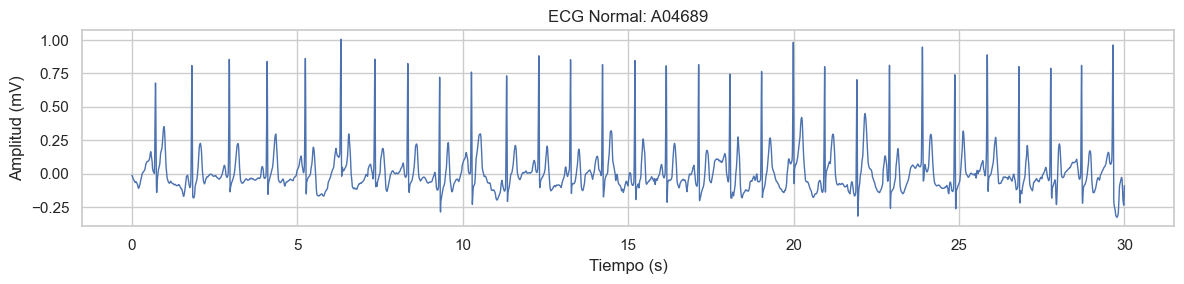

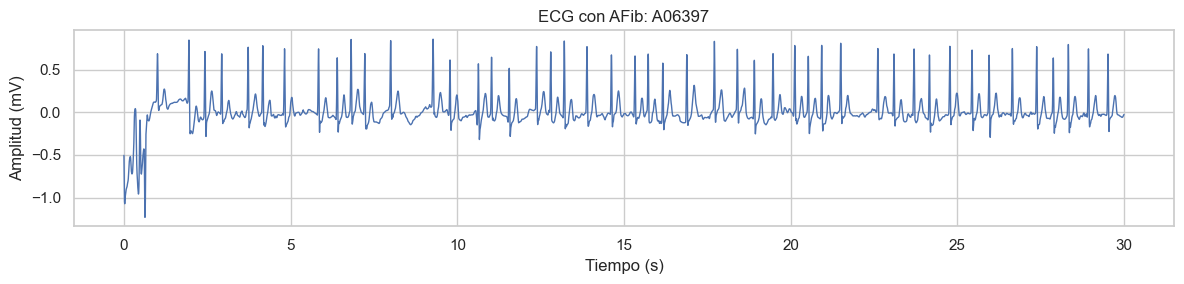

In [10]:
import wfdb
import matplotlib.pyplot as plt
import os

# Ruta al directorio donde están los .mat/.hea
DATASET_DIR = "training2017"

# Buscar un ejemplo Normal y uno con AFib
normal_id = df[df['label'] == 'N'].iloc[0]['id']
afib_id = df[df['label'] == 'A'].iloc[0]['id']

# Función para mostrar ECG
def mostrar_ecg(ecg_id, titulo):
    record_path = os.path.join(DATASET_DIR, ecg_id)
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]
    fs = record.fs
    tiempo = [i / fs for i in range(len(signal))]

    plt.figure(figsize=(12, 3))
    plt.plot(tiempo, signal, linewidth=1)
    plt.title(titulo)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (mV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Mostrar ECG Normal
mostrar_ecg(normal_id, f"ECG Normal: {normal_id}")

# Mostrar ECG con AFib 
mostrar_ecg(afib_id, f"ECG con AFib: {afib_id}")


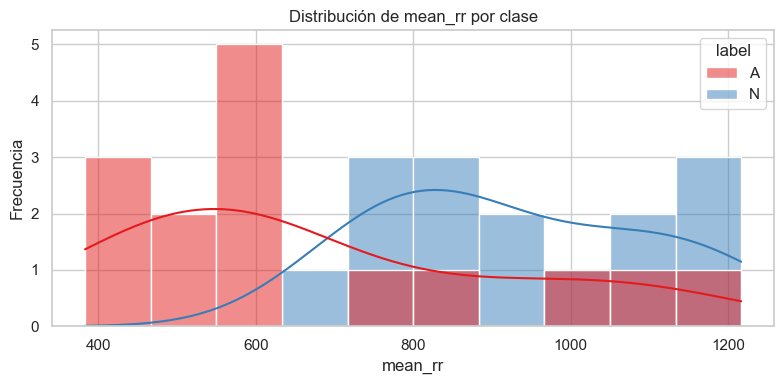

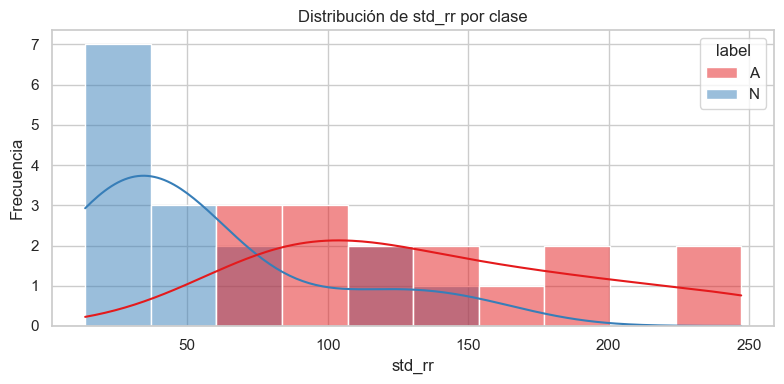

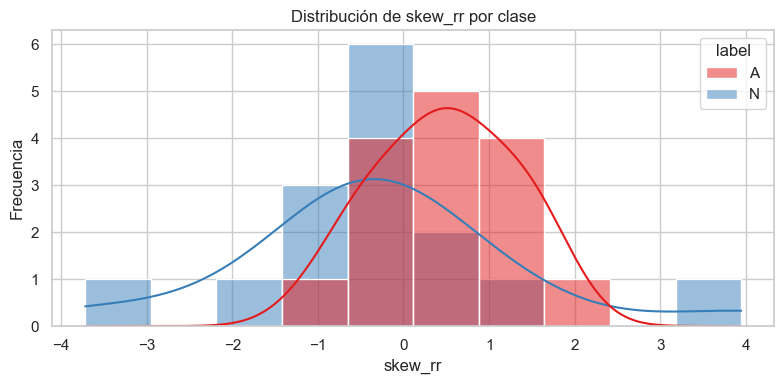

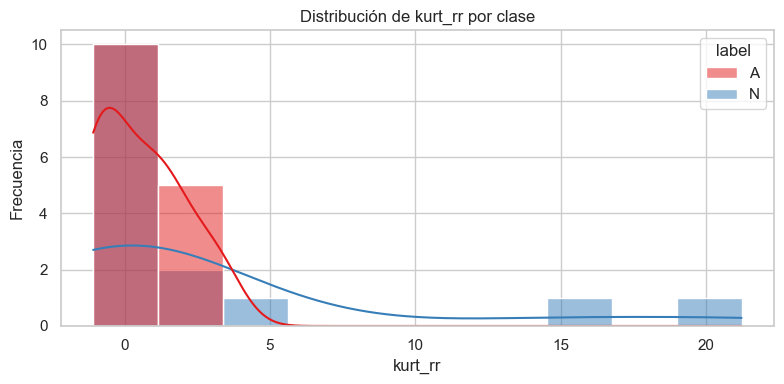

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar CSV balanceado
df = pd.read_csv("ecg_rr_features_30_balanceado.csv")

# Estilo general
sns.set(style="whitegrid")

# Variables a analizar
variables = ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']

# Histograma con KDE por variable
for var in variables:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=var, hue='label', kde=True, palette='Set1', bins=10)
    plt.title(f"Distribución de {var} por clase")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show() 
